# Teoría de portafolios

Mariana Carmona

In [34]:
import numpy as np
import pandas as pd
import pandas_datareader.data as wb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from datetime import datetime
import yfinance as yf
import seaborn as sns
from scipy.stats import norm

In [35]:
#activos = ['MCD', 'WMT', 'KO', 'T', 'BAC', 'KHC', 'BA', 'TSLA', 'AMZN', 'AAPL',
#      'VZ', 'PFE', 'GS', 'MMM', 'AXP', 'CAT', 'UL', 'COST', 'XOM']

In [36]:
activos = ['IBM', 'AMZN', 'AAPL']

In [37]:
# Definir el rango de fechas
fecha_inicio = '2015-12-01'
fecha_fin = '2020-11-30'

# Crear DataFrame vacío para almacenar los precios mensuales
df = pd.DataFrame()

# Descargar precios mensuales para cada activo
for t in activos:
    # Utilizar 'yf.download' para obtener los precios de Yahoo Finance
    data = yf.download(t, start=fecha_inicio, end=fecha_fin)
    
    # Agregar la columna al DataFrame 'df' con el nombre del activo
    df[t] = data['Adj Close'].resample('MS').first()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [38]:
#df = pd.read_csv("precios.csv")
#df['Date'] = pd.to_datetime(df['Date'])
#df.set_index('Date', inplace = True)

In [39]:
df.head()

,IBM,AMZN,AAPL
Date,,,
2015-12-01,94.957664,33.952999,26.741564
2016-01-01,91.375259,31.849501,24.009068
2016-02-01,83.901253,28.740499,21.976219
2016-03-01,91.235809,28.952000,23.034914
2016-04-01,103.559464,29.924999,25.202532


## Optimización algorítmica (Markowitz)

In [40]:
# Calcular los cambios porcentuales en todas las columnas numéricas
retornos_log = np.log(1+df.pct_change())
# Si deseas mantener solo los cambios porcentuales y eliminar la primera fila (que contiene NaN)
retornos_log = retornos_log.dropna()
retornos_log.head()

,IBM,AMZN,AAPL
Date,,,
2016-01-01,-0.038456,-0.063955,-0.107787
2016-02-01,-0.085334,-0.102714,-0.088471
2016-03-01,0.083807,0.007332,0.047050
2016-04-01,0.126699,0.033055,0.089933
2016-05-01,-0.048702,0.133312,-0.160932


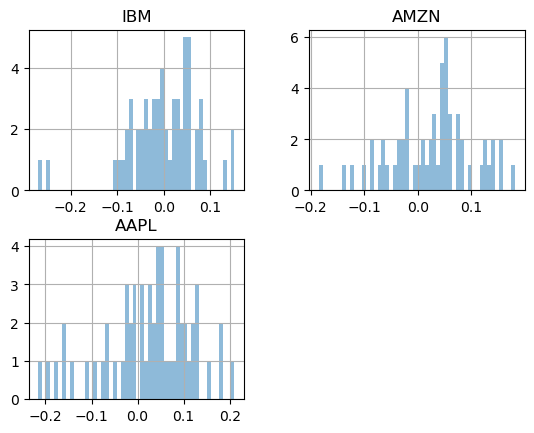

In [41]:
retornos_log.hist(bins=50,histtype="stepfilled",alpha=0.5)
plt.show()

In [42]:
matriz_cov = retornos_log.cov()

In [43]:
matriz_cov.head()

,IBM,AMZN,AAPL
IBM,0.005822,0.002772,0.003409
AMZN,0.002772,0.006022,0.004257
AAPL,0.003409,0.004257,0.009093


Al multiplicar las matrices por 12 para ajustar los cálculos a una base anual, se están calculando los pesos que maximizan la cartera en un plazo de un año. El resultado de la optimización se expresará en términos anuales, lo que significa que representa el rendimiento y la volatilidad de la cartera en un horizonte de tiempo de un año.


Al realizar la optimización, se están buscando los pesos óptimos para los activos en la cartera que maximicen el índice de Sharpe anualizado. El índice de Sharpe anualizado es una medida de la rentabilidad ajustada al riesgo anualizada, lo que te permite comparar diferentes estrategias de inversión en un horizonte de tiempo de un año.


Es importante tener en cuenta que al utilizar datos históricos para estimar los rendimientos y la volatilidad de los activos, se está asumiendo que las características pasadas de los activos reflejarán su comportamiento futuro. Sin embargo, los mercados financieros son dinámicos y pueden cambiar, por lo que los resultados obtenidos a través de la optimización basada en datos históricos pueden no garantizar un rendimiento similar en el futuro.


In [44]:
# Simulación de pesos, retornos y volatilidades
port_retornos = []
port_vols = []

for i in range(1000):
    num_activos = len(retornos_log.columns)
    pesos = np.random.random(num_activos)
    pesos /= np.sum(pesos)
    port_retornos.append(np.sum(pesos*retornos_log.mean())*12)
    port_vols.append(np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*12,pesos))))

port_retornos = np.array(port_retornos)
port_vols = np.array(port_vols)

In [45]:
# Función que empaqueta la volatilidad, los retornos y el ratio sharpe
def estadisticos_portafolio(pesos, retornos_log, matriz_cov):
    #Se calculan los retornos anuales esperados para cada portafolio utilizando: 
    port_retornos = np.sum(pesos*retornos_log.mean())*12 
    
    # Se calcula la volatilidad anual de cada portafolio utilizando:
    port_vols = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*12,pesos)))
    sharpe = port_retornos / port_vols
    return {'Retornos': port_retornos, 'Volatilidad': port_vols, 'Sharpe': sharpe}

La razón detrás de tomar el negativo del Sharpe Ratio es porque la optimización busca maximizar una función, pero la función optimize.minimize() está diseñada para minimizar una función. 
Entonces, maximizar el Sharpe Ratio es equivalente a minimizar su negativo.

In [46]:
def minimize_sharpe (pesos, retornos_log, matriz_cov):
    return -estadisticos_portafolio(pesos, retornos_log, matriz_cov)['Sharpe']

In [47]:
# Condiciones y restricciones para minimizar el Sharpe Ratio con optimize.minimize
inicializador = num_activos * [1./num_activos]
bounds = tuple((0,1) for x in range(num_activos))

# Se agrega la restricción de que la suma de los pesos sea igual a 1
suma_pesos_restriccion = {'type': 'eq', 'fun': lambda pesos: np.sum(pesos) - 1}

# Lista de restricciones, que en este caso es solo la suma de los pesos
restricciones = [suma_pesos_restriccion]

El portafolio óptimo que maximiza el índice de Sharpe con la restricción de la suma de pesos igual a 1 es:

In [48]:
sharpe_optimo = optimize.minimize(minimize_sharpe, inicializador, method = 'SLSQP', args=(retornos_log, matriz_cov), bounds=bounds, constraints=restricciones)
sharpe_optimo_pesos = sharpe_optimo['x'].round(3)
estadisticos_optimos = estadisticos_portafolio(sharpe_optimo_pesos, retornos_log, matriz_cov)

In [49]:
print('Pesos óptimos de la cartera: ', list(zip(activos, list(sharpe_optimo_pesos*100))))
print('Retorno óptimo de la cartera: ', np.round(estadisticos_optimos['Retornos']*100,3))
print('Volatilidad óptima de la cartera: ', np.round(estadisticos_optimos['Volatilidad']*100,3))
print('Sharpe óptimo de la cartera: ', np.round(estadisticos_optimos['Sharpe'],3))

Pesos óptimos de la cartera:  [('IBM', 0.0), ('AMZN', 79.2), ('AAPL', 20.8)]
Retorno óptimo de la cartera:  29.815
Volatilidad óptima de la cartera:  25.861
Sharpe óptimo de la cartera:  1.153


In [50]:
sharpe = port_retornos / port_vols
max_sr_retornos = port_retornos[sharpe.argmax()]
max_sr_volatilidad = port_vols[sharpe.argmax()]

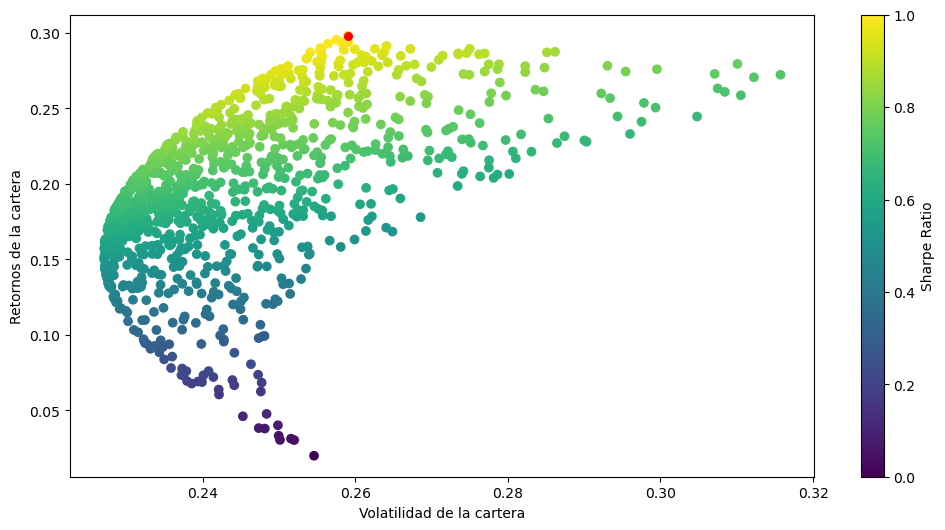

In [51]:
plt.figure(figsize=(12,6))
plt.scatter(port_vols, port_retornos, c = (port_retornos / port_vols))
plt.scatter(max_sr_volatilidad, max_sr_retornos, c='red', s=30)
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Volatilidad de la cartera')
plt.ylabel('Retornos de la cartera')
plt.show()

# Montecarlo - Cholesky

Generar simulaciones de una cartera utilizando el método de Montecarlo y la descomposición de Cholesky es una técnica común en finanzas para evaluar el rendimiento y el riesgo de una cartera de activos. A continuación, te presento el procedimiento general para llevar a cabo este tipo de simulación:

1. Obtener datos históricos: Lo primero que necesitas es obtener los datos históricos de los activos que conforman la cartera. 

2. Calcular los rendimientos diarios: A partir de los datos históricos, calcula los rendimientos para cada activo. Los rendimientos se pueden obtener mediante la siguiente fórmula:

3. Calcular la matriz de covarianza: La matriz de covarianza es un elemento crucial en la simulación de Montecarlo. Representa las relaciones de variación conjunta entre los diferentes activos de la cartera

4. Calcular la matriz de correlación: La matriz de correlación es una versión normalizada de la matriz de covarianza y se utiliza para la descomposición de Cholesky. 

5. Realizar la descomposición de Cholesky: La descomposición de Cholesky es un procedimiento para factorizar la matriz de correlación en el producto de una matriz triangular inferior y su traspuesta. Esto te permitirá generar variables aleatorias con una distribución normal multivariante con la misma estructura de correlación que tus activos originales.

6. Generar escenarios aleatorios: A partir de la descomposición de Cholesky, genera escenarios aleatorios de rendimientos para cada activo en la cartera. Puedes hacer esto generando una serie de números aleatorios con distribución normal estándar y luego multiplicándolos por la matriz triangular obtenida en el paso anterior.

7. Calcular los valores de la cartera: Utiliza los rendimientos simulados para calcular los valores de la cartera en cada escenario. Para hacer esto, simplemente multiplica los rendimientos simulados por los valores iniciales de la cartera y suma los resultados para obtener el valor total de la cartera en cada simulación.

8. Analizar los resultados: Con las simulaciones generadas, puedes analizar el comportamiento de la cartera en diferentes escenarios y evaluar su rendimiento y riesgo bajo diversas condiciones de mercado.

Se utilizarán las variables previamente establecidas:
* activos
* num_activos
* sharpe_optimo_pesos
* retornos_log 
* matriz_cov

In [52]:
pruebas = 5000
tiempo = 12 

**chol = np.linalg.cholesky(matriz_cov)**: Calcula la descomposición de Cholesky de la matriz de covarianzas matriz_cov. La descomposición de Cholesky es una forma de factorizar una matriz simétrica y definida positiva en el producto de una matriz triangular inferior y su traspuesta. Esta descomposición se utiliza para generar muestras aleatorias con una covarianza específica.

**u = norm.ppf(np.random.rand(num_activos, num_activos))**: Genera una matriz u de tamaño (num_activos, num_activos) con valores aleatorios extraídos de una distribución normal estándar utilizando np.random.rand. Luego, aplica la función norm.ppf para obtener la función inversa (percentil) de la distribución normal estándar en cada valor aleatorio generado. Esto transforma los valores aleatorios en valores que siguen una distribución normal.

**Lu = chol.dot(u)**: Realiza la multiplicación de matrices entre la matriz de Cholesky chol y la matriz u, lo que produce otra matriz Lu. Estas operaciones generan las muestras aleatorias que seguirán la distribución normal con la covarianza deseada.

La función norm.ppf() es una función de la biblioteca scipy.stats que se utiliza para calcular el percentil de una distribución normal inversa. En otras palabras, dada una probabilidad p, norm.ppf(p) devuelve el valor x tal que la probabilidad acumulada de la distribución normal estándar hasta x sea igual a p.

La función norm.ppf() es útil en diversos contextos, especialmente en estadísticas y análisis de datos, donde es necesario calcular los valores críticos o puntos de corte para un nivel de confianza o significancia dado en distribuciones normales.

In [53]:
chol = np.linalg.cholesky(matriz_cov)

**simulaciones = np.full(shape=(tiempo, pruebas), fill_value=0.0)**: Crea un array bidimensional de tamaño (tiempo, pruebas) y llena todas las celdas con el valor 0.0. Aquí, tiempo representa el número de periodos en la simulación y pruebas es el número de muestras que se generarán.

**cartera = float(500000)**: Define una variable llamada Cartera con un valor de 500000. Representa el valor inicial de una cartera.

In [54]:
simulaciones = np.full(shape=(tiempo+1, 5000), fill_value=0.0)
cartera = float(500000) # valor inicial de la carttera
simulaciones[0,:] = cartera

for j in range(1,tiempo+1):
    for i in range(0, 5000):
        Z = norm.ppf(np.random.rand(1, num_activos))
        retornos_tiempo = np.inner(chol,Z) 
        #como se estuvo trabajando con retornos que se sacaron de manera logarítmica, entonces 
        #la tasa de crecimiento se obtiene con una exponencial
        tasa_port= np.inner(sharpe_optimo_pesos, np.exp(retornos_tiempo.T))
        simulaciones[j, i] = tasa_port*simulaciones[j-1,i]

## Componente determinista

**En caso de querer agregar una componente determinista, será necesario combinar los cambios esperados en los rendimientos de los activos con las fluctuaciones aleatorias (volatilidad) en sus rendimientos y asegura que los retornos simulados reflejen tanto la tendencia esperada como la variabilidad estocástica, tomando en cuenta las correlaciones entre los activos.**

In [55]:
#m = retornos_log.mean()
#var = retornos_log.var()
#drift = m*0.5*var
#stdev = retornos_log.std()

El término "drift" se utiliza para calcular el componente determinista del cambio esperado en el valor de los activos en cada período de tiempo durante la simulación de Montecarlo. El drift se basa en la media (mean) y la varianza (var) de los retornos logarítmicos históricos de los activos en la cartera.

El cálculo del drift generalmente está relacionado con el modelo de rendimiento utilizado en la simulación. En este caso, se estaría utilizando un modelo de rendimiento simple que asume un componente determinista en el cambio de los precios de los activos. Esta componente determinista es el "drift".

En concreto, el cálculo del drift se realiza mediante la fórmula:

```
drift = m * 0.5 * var
```

Donde:
- `m` es la media (mean) de los retornos logarítmicos históricos de los activos.
- `var` es la varianza (var) de los retornos logarítmicos históricos de los activos.

La idea detrás de esta fórmula es que el drift representa la tasa esperada de crecimiento (o decrecimiento) de los activos debido a su componente determinista. Es un término que se agrega para tener en cuenta la tendencia de los retornos en la simulación y modelar una posible tendencia alcista o bajista en el mercado.

En el código, se utiliza el drift junto con una matriz aleatoria `Z` (que contiene números aleatorios con distribución normal estándar) para calcular los retornos esperados de los activos en cada período de tiempo de la simulación. Esta multiplicación de `drift` por una matriz aleatoria permite simular los cambios esperados en los precios de los activos a lo largo del tiempo y es un paso fundamental en la generación de las simulaciones utilizando el método de Montecarlo y la descomposición de Cholesky.

En caso de que se quiera agregar una componente determinista a la componente estocástica se seguiría el código:

`simulaciones = np.full(shape=(tiempo+1, pruebas), fill_value=0.0)
cartera = float(500000)`

`for i in range(0,pruebas):
    Z = norm.ppf(np.random.rand(tiempo+1, num_activos))
    #Retornos simulados de los tres activos considerando la covarianza específica entre activos
    retornos_tiempo = np.inner(chol,Z)
    #como se estuvo trabajando con retornos que se sacaron de manera logarítmica, entonces 
    #la tasa de crecimiento se obtiene con una exponencial
    simulaciones[:,i] = np.cumprod(np.inner(sharpe_optimo_pesos, np.exp(retornos_tiempo.T)))*cartera
    #Las siguientes líneas son en caso de que se quiera agregar una componente determinista a 
    #la componente estocástica
    #retornos_tiempo = np.inner(chol, drift.values + stdev.values*Z) # es una matriz del tamaño de Z
    #simulaciones[:,i] = np.cumprod(np.inner(sharpe_optimo_pesos, retornos_tiempo.T)+1)*cartera
    # Asignar la fila de 'cartera' a la primera fila de 'simulaciones'
    simulaciones[0] = cartera'`

Vamos a analizar cada parte del código:

1. `for i in range(0, pruebas):`: Este bucle for se encarga de realizar la simulación `pruebas` veces, donde `pruebas` es el número total de simulaciones que se desean realizar.

2. `Z = norm.ppf(np.random.rand(tiempo, num_activos))`: Se generan muestras aleatorias que siguen una distribución normal estándar utilizando `np.random.rand(tiempo, num_activos)` y luego se aplica `norm.ppf()` para obtener los valores transformados que siguen una distribución normal. Estos valores aleatorios se almacenan en la variable `Z`.

3. `retornos_tiempo = np.inner(chol, drift.values + stdev.values*Z)`: Se calcula la matriz `retornos_tiempo` mediante la multiplicación de la matriz de Cholesky `chol` por la suma de los valores de deriva (`drift.values`) y los valores de desviación estándar (`stdev.values`) multiplicados por los valores aleatorios generados `Z`. Esta matriz representa los retornos de cada activo en diferentes periodos de tiempo, simulados aleatoriamente.

4. `simulaciones[:, i] = np.cumprod(np.inner(sharpe_optimo_pesos, retornos_tiempo.T) + 1) * cartera`: Se realiza la simulación de la cartera para cada uno de los retornos de tiempo simulados. Primero, se calcula el producto acumulado de los retornos de la cartera multiplicados por los pesos óptimos calculados previamente (`sharpe_optimo_pesos`) y sumándoles 1. Luego, se multiplica este resultado por el valor inicial de la cartera (`cartera`) para obtener la evolución de la cartera a lo largo del tiempo en la simulación `i`. Los resultados se almacenan en la columna `i` de la matriz `simulaciones`.

5. `simulaciones[0] = cartera`: Se establece el valor inicial de la cartera (`cartera`) en la primera fila de la matriz `simulaciones`. Esto se hace para asegurarse de que cada simulación comience con el mismo valor inicial de la cartera.

Este código realiza simulaciones de montecarlo para generar diferentes trayectorias posibles del valor de una cartera de activos financieros a lo largo del tiempo, teniendo en cuenta la covarianza entre los activos y los pesos óptimos calculados para maximizar el índice de Sharpe. El resultado final es una matriz `simulaciones` de tamaño `(tiempo, pruebas)` que contiene las diferentes evoluciones de la cartera en cada simulación. Cada columna de la matriz representa una simulación diferente y cada fila representa el valor de la cartera en diferentes periodos de tiempo.

### Componente determinista por componente estocástica

La matriz de Cholesky multiplicada por `(drift.values + stdev.values * Z)` es una parte esencial del proceso de generación de los retornos simulados para los activos de la cartera en cada período de tiempo durante la simulación de Montecarlo.

Recapitulemos algunos elementos involucrados en esta multiplicación:

1. `drift`: Es el componente determinista del cambio esperado en los retornos de los activos. Representa la tasa esperada de crecimiento o decrecimiento debido a factores deterministas, como tendencias económicas o eventos específicos.

2. `stdev`: Es la desviación estándar de los retornos de los activos. Es una medida de la volatilidad, que captura la incertidumbre y la variabilidad en los rendimientos.

3. `Z`: Es una matriz de números aleatorios generados a partir de una distribución normal estándar. Se utiliza para simular la componente estocástica o aleatoria del cambio en los retornos de los activos.

Al multiplicar la matriz de Cholesky por `(drift.values + stdev.values * Z)`, estamos combinando tanto la componente determinista como la componente estocástica en el cálculo de los retornos simulados para los activos en cada período de tiempo.

La descomposición de Cholesky se utiliza para generar variables aleatorias con una distribución normal multivariante que tenga la misma estructura de correlación que los activos originales en la cartera. En otras palabras, se utiliza para generar una matriz de números aleatorios que representen la componente estocástica de los rendimientos de los activos, pero teniendo en cuenta las relaciones de correlación entre ellos.

Al multiplicar la matriz de Cholesky por `(drift.values + stdev.values * Z)`, estamos aplicando esta componente estocástica a los cambios esperados en los rendimientos de los activos, teniendo en cuenta las correlaciones entre ellos. Esto nos permite obtener los retornos simulados para cada activo en cada período de tiempo, teniendo en cuenta tanto el componente determinista (drift) como la componente estocástica (representada por la matriz de Cholesky y Z).

Esta multiplicación combina los cambios esperados en los rendimientos de los activos con las fluctuaciones aleatorias (volatilidad) en sus rendimientos y asegura que los retornos simulados reflejen tanto la tendencia esperada como la variabilidad estocástica, tomando en cuenta las correlaciones entre los activos.

### Como en el caso particular que se está desarrollando en este Notebook no nos interesa la componente determinista, entonces continuaremos con la gráfica de las Simulaciones Montecarlo

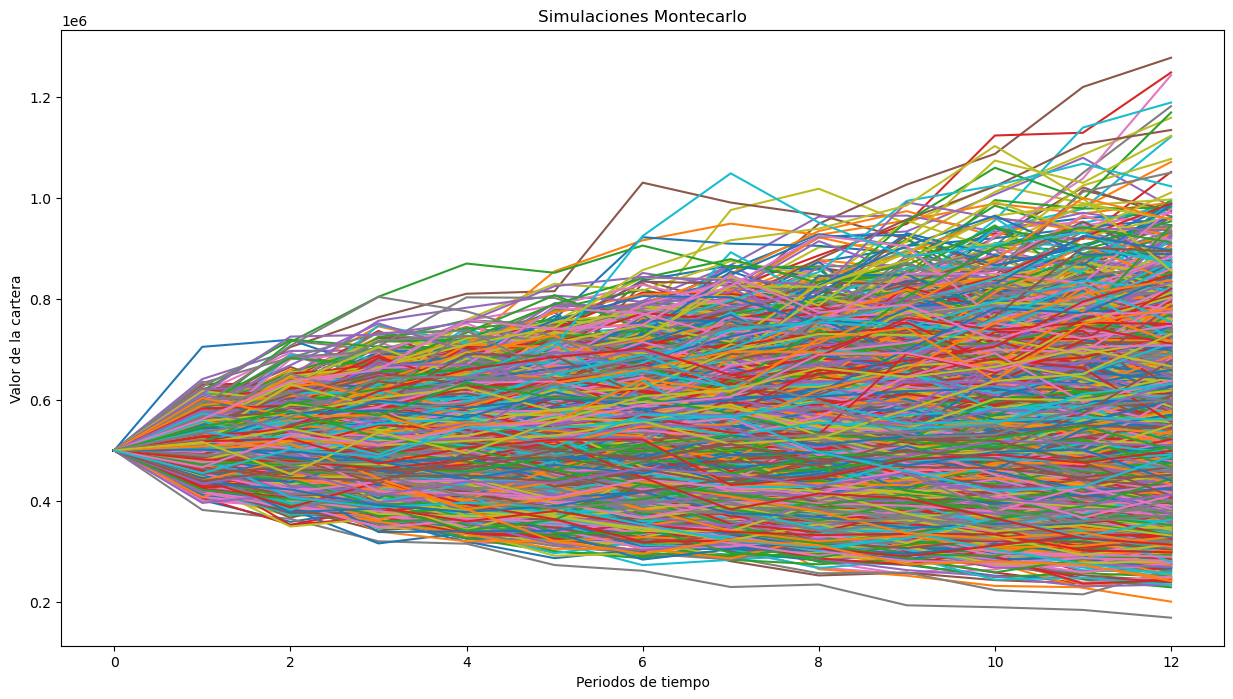

In [56]:
plt.figure(figsize=(15,8))
plt.plot(simulaciones)
plt.ylabel('Valor de la cartera')
plt.xlabel('Periodos de tiempo')
plt.title('Simulaciones Montecarlo')
plt.show()

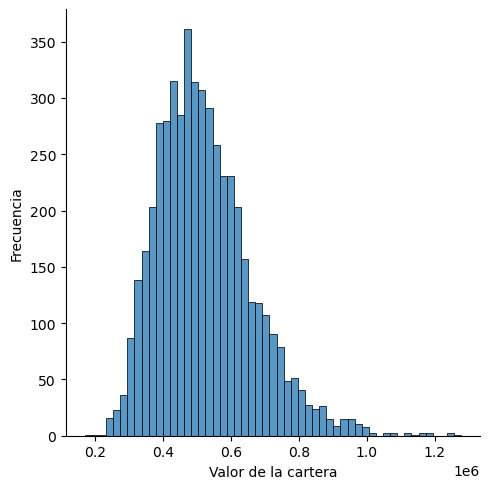

In [57]:
sns.displot(pd.DataFrame(simulaciones).iloc[-1])
plt.xlabel('Valor de la cartera')
plt.ylabel('Frecuencia')
plt.show()

# VaR - Value at Risk

El Valor en Riesgo (VaR) es una medida utilizada en el campo de la gestión de riesgos para estimar las pérdidas potenciales que podría enfrentar un portafolio de inversión o una empresa en un período de tiempo específico, bajo ciertos niveles de confianza. Existen varios métodos para calcular el VaR, y a continuación, te explico los procedimientos para calcularlo utilizando los métodos paramétrico, histórico y con Monte Carlo:

**1. VaR Paramétrico:**
El método paramétrico se basa en supuestos de normalidad y volatilidad constante de los rendimientos del activo o portafolio. El cálculo del VaR paramétrico involucra los siguientes pasos:

Paso 1: Obtener los rendimientos históricos del activo o portafolio en el que se desea calcular el VaR.

Paso 2: Calcular la media (μ) y la desviación estándar (σ) de los rendimientos. Estos valores se utilizan para asumir que los rendimientos siguen una distribución normal.

Paso 3: Determinar el nivel de confianza deseado. Por ejemplo, si deseas un VaR al 95% de confianza, el nivel de confianza (α) será 5%.

Paso 4: Calcular el VaR paramétrico utilizando la fórmula:
VaR_parametrico = μ - (Z * σ)

Donde Z es el valor crítico de la distribución normal estándar correspondiente al nivel de confianza α. Para un nivel de confianza del 95%, Z es aproximadamente 1.65.

**2. VaR Histórico:**
El método histórico se basa únicamente en los datos históricos de los rendimientos, lo que lo hace más robusto ante supuestos sobre la distribución de los datos. Los pasos para calcular el VaR histórico son los siguientes:

Paso 1: Obtener una serie de datos históricos de los rendimientos del activo o portafolio.

Paso 2: Ordenar los datos históricos de rendimientos de menor a mayor.

Paso 3: Determinar el nivel de confianza deseado, al igual que en el método paramétrico.

Paso 4: Calcular el VaR histórico como el percentil correspondiente al nivel de confianza α. Por ejemplo, si deseas un VaR al 95% de confianza, deberás seleccionar el rendimiento que se encuentra en el percentil 5 de la serie de datos ordenados.

**3. VaR con Monte Carlo:**
El método de Monte Carlo es una técnica que utiliza simulaciones aleatorias para estimar el VaR. El procedimiento general es el siguiente:

Paso 1: Modelar el comportamiento de los rendimientos del activo o portafolio mediante una distribución de probabilidad adecuada. Esto puede incluir el uso de distribuciones históricas o modelos matemáticos más complejos, como el modelo de Black-Scholes para opciones financieras.

Paso 2: Generar numerosas simulaciones aleatorias de los rendimientos futuros del activo o portafolio, utilizando la distribución de probabilidad obtenida en el paso anterior.

Paso 3: Calcular el VaR como el percentil correspondiente al nivel de confianza α de la distribución de los resultados de las simulaciones. Al igual que en el método histórico, si deseas un VaR al 95% de confianza, deberás seleccionar el rendimiento que se encuentra en el percentil 5 de las simulaciones.

Cabe destacar que el método de Monte Carlo puede ser más preciso que los enfoques paramétrico e histórico, especialmente cuando las distribuciones de los rendimientos son más complejas y no se ajustan bien a una distribución normal.

En todos los casos, es fundamental considerar las limitaciones y supuestos de cada método, así como la calidad y cantidad de datos disponibles para obtener estimaciones más precisas del VaR. Además, el VaR es solo una medida de riesgo y no cubre todas las fuentes de riesgo posibles, por lo que es importante complementarlo con otras métricas y técnicas de gestión de riesgos.

Se utilizarán las variables previamente establecidas:
* activos
* num_activos
* sharpe_optimo_pesos
* retornos_log 
* matriz_cov
* cartera

## VaR Paramétrico

Calculamos `la media y la desviación estándar de los rendimientos de la cartera` utilizando los pesos dados.
Además, recordemos que el monto inicial de inversión está representado por la varible `cartera`

In [58]:
port_media = retornos_log.mean().dot(sharpe_optimo_pesos)
port_stdev = np.sqrt(sharpe_optimo_pesos.T.dot(matriz_cov).dot(sharpe_optimo_pesos))

Calculamos `el valor esperado y la desviación estándar de la inversión` utilizando la media y la desviación estándar de la cartera.
Establecemos el nivel de confianza (confianza) en 0.05 (5%).

In [59]:
media_inver = (1+port_media) * cartera
stdev_inver = cartera * port_stdev

Establecemos el nivel de confianza (confianza) en 0.05 (5%).

Calculamos el VaR para un horizonte un periodo de tiempo T utilizando la función inversa de la distribución acumulativa normal (función cuantil) con el nivel de confianza, la media y la desviación estándar.

In [60]:
nivel_conf = 0.05
cut = norm.ppf(nivel_conf, media_inver, stdev_inver)
var_1T = cartera - cut 
var_1T

48974.00434509583

Calculamos la pérdida potencial de la cartera en el nivel de confianza dado y para diferentes horizontes de tiempo (desde 1 hasta 12 meses).

Imprimimos los resultados, mostrando la pérdida potencial máxima de la inversión inicial para cada mes en el horizonte de tiempo dado.


La pérdida máxima de tu cartera inicial de 500000.0 usd con un nivel de confianza del 95.0% y para los siguientes 12 meses es de:

A 1 meses, VaR(95.0%) = 48974.0   Portfolio : 512423.09
A 2 meses, VaR(95.0%) = 69259.7   Portfolio : 525154.84
A 3 meses, VaR(95.0%) = 84825.46   Portfolio : 538202.93
A 4 meses, VaR(95.0%) = 97948.01   Portfolio : 551575.22
A 5 meses, VaR(95.0%) = 109509.2   Portfolio : 565279.75
A 6 meses, VaR(95.0%) = 119961.32   Portfolio : 579324.79
A 7 meses, VaR(95.0%) = 129573.04   Portfolio : 593718.8
A 8 meses, VaR(95.0%) = 138519.4   Portfolio : 608470.44
A 9 meses, VaR(95.0%) = 146922.01   Portfolio : 623588.6
A 10 meses, VaR(95.0%) = 154869.4   Portfolio : 639082.4
A 11 meses, VaR(95.0%) = 162428.4   Portfolio : 654961.15
A 12 meses, VaR(95.0%) = 169650.93   Portfolio : 671234.43


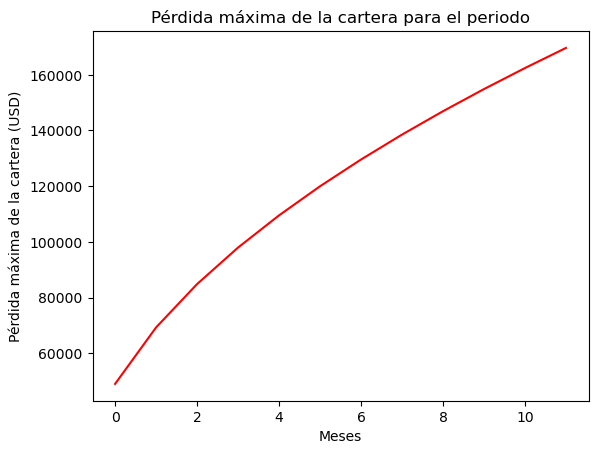

In [61]:
print(("\nLa pérdida máxima de tu cartera inicial de " + str(cartera) + 
    " usd con un nivel de confianza del " + str((1 - nivel_conf) * 100) + "% y para los siguientes " + str(tiempo) + " meses es de:\n"))

var_array = []

for i in range(1, tiempo+1):
    var_array.append(np.round(var_1T * np.sqrt(i), 2))
    print("A " + str(i) + " meses, VaR(" + str((1 - nivel_conf) * 100) + "%) = " + str(((np.round(var_1T * np.sqrt(i), 2))))+ "   Portfolio : " +str((np.round(cartera * (1+port_media)**(i),2 ))))

plt.xlabel("Meses")
plt.ylabel("Pérdida máxima de la cartera (USD)")
plt.title("Pérdida máxima de la cartera para el periodo")
plt.plot(var_array,"r")
plt.show()

## VaR con Monte Carlo

In [62]:
simul = pd.DataFrame(simulaciones)

In [63]:
print(("\nLa pérdida máxima de tu cartera inicial de " + str(cartera) + 
    " usd con un nivel de confianza del " + str((1 - nivel_conf) * 100) + "% y para los siguientes " + str(tiempo) + " meses es de:\n"))

simul = pd.DataFrame(simulaciones)
var_95_conf  = []
n = len(simul.iloc[1])
posicion_percentil = int(0.05 * (n + 1)) 

for i in range(1, tiempo+1):
    rendimientos_ordenados = sorted(simul.iloc[i])
    # Calcula la posición del percentil 5
    var_95_conf.append(500000-rendimientos_ordenados[posicion_percentil - 1])
    print("A " + str(i) + " meses, VaR(" + str((1 - nivel_conf) * 100) + "%) = " + str(round(500000-rendimientos_ordenados[posicion_percentil-1],2))+ "   Portfolio : "  + str(round(simul.iloc[i].mean(),2)))



La pérdida máxima de tu cartera inicial de 500000.0 usd con un nivel de confianza del 95.0% y para los siguientes 12 meses es de:

A 1 meses, VaR(95.0%) = 57724.73   Portfolio : 502117.62
A 2 meses, VaR(95.0%) = 79057.62   Portfolio : 503560.38
A 3 meses, VaR(95.0%) = 96282.3   Portfolio : 505339.85
A 4 meses, VaR(95.0%) = 108028.14   Portfolio : 506980.06
A 5 meses, VaR(95.0%) = 117711.99   Portfolio : 509011.3
A 6 meses, VaR(95.0%) = 129551.09   Portfolio : 511283.18
A 7 meses, VaR(95.0%) = 134980.66   Portfolio : 512482.6
A 8 meses, VaR(95.0%) = 143698.77   Portfolio : 514446.82
A 9 meses, VaR(95.0%) = 152355.71   Portfolio : 516814.62
A 10 meses, VaR(95.0%) = 156494.79   Portfolio : 517917.18
A 11 meses, VaR(95.0%) = 163440.34   Portfolio : 520603.76
A 12 meses, VaR(95.0%) = 169759.96   Portfolio : 521934.05


print(("\nLa pérdida máxima de tu cartera inicial de " + str(cartera) + 
    " usd con un nivel de confianza del " + str((1 - nivel_conf) * 100) + "% y para los siguientes " + str(tiempo) + " meses es de:\n"))

var_95_conf  = []
n = len(simul.iloc[i])
posicion_percentil = int(0.05 * (n + 1)) 

for i in range(1, tiempo+1):
    rendimientos_ordenados = sorted(simul.iloc[i])
    # Calcula la posición del percentil 5
    var_95_conf.append(500000-rendimientos_ordenados[posicion_percentil - 1])
    print("A " + str(i) + " meses, VaR(" + str((1 - nivel_conf) * 100) + "%) = " + str(round(500000-rendimientos_ordenados[posicion_percentil-1],2))+ "   Portfolio : "  + str(round(simul.iloc[i].mean(),2)))


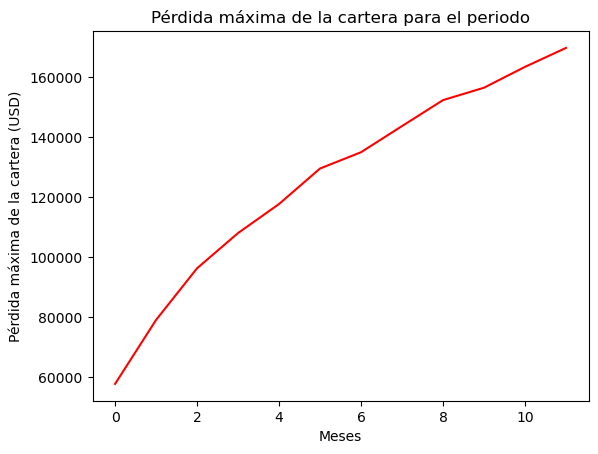

In [64]:
plt.xlabel("Meses")
plt.ylabel("Pérdida máxima de la cartera (USD)")
plt.title("Pérdida máxima de la cartera para el periodo")
plt.plot(var_95_conf,"r")

### Simulación para una sola cartera

In [65]:
simulaciones1 = np.full(shape=(1, 5000), fill_value=0.0)
cartera = float(500000)
#simulaciones1[0,:] = cartera

for i in range(1, 5000):
    Z1 = norm.ppf(np.random.rand(1, num_activos))
    retornos_tiempo1 = np.inner(chol,Z1)
    tasa_port1= np.inner(sharpe_optimo_pesos, np.exp(retornos_tiempo1.T))*cartera
    simulaciones1[0,i] = tasa_port1
    #print(tasa_port1)
#    for j in range(1,2):
 #       simulaciones1[j, i] = tasa_port1*simulaciones[j-1,i]

    #retornos_tiempo = np.inner(chol, drift.values + stdev.values*Z) # es una matriz del tamaño de Z
    # simulaciones[:,i] = np.cumprod(np.inner(sharpe_optimo_pesos, np.exp(retornos_tiempo.T)))*cartera
    #simulaciones[:,i] = np.cumprod(np.inner(sharpe_optimo_pesos, retornos_tiempo.T)+1)*cartera
    # Asignar la fila de 'cartera' a la primera fila de 'simulaciones'
    #simulaciones[0] = cartera

In [66]:
simul1 = pd.DataFrame(simulaciones1.T)
rendimientos_ordenados1 = sorted(simul1.iloc[:,0])
n1 = len(rendimientos_ordenados1)
posicion_percentil1 = int(0.05 * (n1 + 1)) 
var_95_conf1 = 500000-rendimientos_ordenados1[posicion_percentil - 1]
var_95_conf1

57826.44141276117